In [26]:
import os
import math
import geopandas as gpd
from shapely.geometry import Point
import shutil
import sys
!{sys.executable} -m pip install osmnx
import osmnx as o
import matplotlib.pyplot as plt
import ast
import zipfile
!{sys.executable} -m pip install geopy
from geopy.geocoders import Nominatim

# Initialize Nominatim API
geolocator = Nominatim(user_agent="MyApp")

In [2]:
def utmToLatLng(easting, northing, zone=2, northernHemisphere=True):
    if not northernHemisphere:
        northing = 10000000 - northing

    a = 6378137
    e = 0.081819191
    e1sq = 0.006739497
    k0 = 0.9996

    arc = northing / k0
    mu = arc / (a * (1 - math.pow(e, 2) / 4.0 - 3 * math.pow(e, 4) / 64.0 - 5 * math.pow(e, 6) / 256.0))

    ei = (1 - math.pow((1 - e * e), (1 / 2.0))) / (1 + math.pow((1 - e * e), (1 / 2.0)))

    ca = 3 * ei / 2 - 27 * math.pow(ei, 3) / 32.0

    cb = 21 * math.pow(ei, 2) / 16 - 55 * math.pow(ei, 4) / 32
    cc = 151 * math.pow(ei, 3) / 96
    cd = 1097 * math.pow(ei, 4) / 512
    phi1 = mu + ca * math.sin(2 * mu) + cb * math.sin(4 * mu) + cc * math.sin(6 * mu) + cd * math.sin(8 * mu)

    n0 = a / math.pow((1 - math.pow((e * math.sin(phi1)), 2)), (1 / 2.0))

    r0 = a * (1 - e * e) / math.pow((1 - math.pow((e * math.sin(phi1)), 2)), (3 / 2.0))
    fact1 = n0 * math.tan(phi1) / r0

    _a1 = 500000 - easting
    dd0 = _a1 / (n0 * k0)
    fact2 = dd0 * dd0 / 2

    t0 = math.pow(math.tan(phi1), 2)
    Q0 = e1sq * math.pow(math.cos(phi1), 2)
    fact3 = (5 + 3 * t0 + 10 * Q0 - 4 * Q0 * Q0 - 9 * e1sq) * math.pow(dd0, 4) / 24

    fact4 = (61 + 90 * t0 + 298 * Q0 + 45 * t0 * t0 - 252 * e1sq - 3 * Q0 * Q0) * math.pow(dd0, 6) / 720

    lof1 = _a1 / (n0 * k0)
    lof2 = (1 + 2 * t0 + Q0) * math.pow(dd0, 3) / 6.0
    lof3 = (5 - 2 * Q0 + 28 * t0 - 3 * math.pow(Q0, 2) + 8 * e1sq + 24 * math.pow(t0, 2)) * math.pow(dd0, 5) / 120
    _a2 = (lof1 - lof2 + lof3) / math.cos(phi1)
    _a3 = _a2 * 180 / math.pi

    latitude = 180 * (phi1 - fact1 * (fact2 + fact3 + fact4)) / math.pi

    if not northernHemisphere:
        latitude = -latitude

    longitude = ((zone > 0) and (6 * zone - 183.0) or 3.0) - _a3

    return (latitude,180+longitude)

In [27]:
data = [
    ("Paris", 2181371),
    ("Marseille", 839043),
    ("Lyon", 472305),
    ("Toulouse", 437715),
    ("Nice", 347060),
    ("Nantes", 282853),
    ("Montpellier", 251634),
    ("Strasbourg", 272975),
    ("Bordeaux", 232260),
    ("Lille", 226014),
    ("Rennes", 209613),
    ("Reims", 183837),
    ("Toulon", 167816),
    ("Saint-Étienne", 177480),
    ("Le Havre", 182580),
    ("Grenoble", 156107),
    ("Dijon", 151504),
    ("Angers", 152337),
    #("Saint-Denis (Réunion)", 138314),
    ("Villeurbanne", 136473),
    ("Nîmes", 144092),
    ("Clermont-Ferrand", 138992),
    ("Aix-en-Provence", 142534),
    ("Le Mans", 144016),
    ("Brest", 144548),
    ("Tours", 136942),
    ("Amiens", 136105),
    ("Limoges", 136539),
    ("Annecy", 51023),
    ("Boulogne-Billancourt", 110251),
    ("Perpignan", 115326),
    ("Metz", 124435),
    ("Besançon", 117080),
    ("Orléans", 113130),
    ("Seine-Saint-Denis", 97875),
    ("Rouen", 107904),
    ("Montreuil", 101587),
    ("Argenteuil", 102683),
    ("Mulhouse", 110514),
    ("Caen", 110399),
    ("Nancy", 105468),
    #("Saint-Paul (Réunion)", 99291),
    ("Roubaix", 97952),
    ("Tourcoing", 92357),
    ("Nanterre", 88316),
    ("Vitry-sur-Seine", 82902),
    ("Créteil", 88939),
    ("Avignon", 92454),
    ("Poitiers", 88776),
    ("Aubervilliers", 73506),
    ("Asnières-sur-Seine", 82351),
    ("Aulnay-sous-Bois", 81600),
    ("Colombes", 82026),
    ("Dunkirk", 69274),
    #("Saint-Pierre (Réunion)", 74480),
    ("Versailles", 87549),
    ("Courbevoie", 84415),
    #("Le Tampon (Réunion)", 69849),
    ("Cherbourg-en-Cotentin", 78549),
    ("Rueil-Malmaison", 77625),
    ("Béziers", 72245),
    ("La Rochelle", 77196),
    ("Champigny-sur-Marne", 74863),
    #("Fort-de-France", 90347),
    ("Pau", 83903),
    ("Saint-Maur-des-Fossés", 75214),
    ("Cannes", 70610),
    ("Antibes", 75820),
    ("Calais", 74888),
    ("Drancy", 66063),
    ("Mérignac", 65469),
    #("Mamoudzou (Mayotte)", 53122),
    ("Saint-Nazaire", 68838),
    ("Ajaccio", 66063),
    ("Colmar", 65713),
    ("Issy-les-Moulineaux", 61471),
    ("Noisy-le-Grand", 61341),
    ("Vénissieux", 57179),
    ("Évry-Courcouronnes", 66851),
    ("Levallois-Perret", 62851),
    ("Cergy", 56873),
    #("Cayenne (French Guiana)", 58004),
    ("Pessac", 57187),
    ("Valence (Drôme)", 65263),
    ("Bourges", 70828),
    ("Ivry-sur-Seine", 55608),
    ("Quimper", 64902),
    ("Clichy", 57162),
    ("La Seyne-sur-Mer", 56768),
    ("Antony", 60552),
    ("Troyes", 61344),
    ("Villeneuve-d'Ascq", 61151),
    ("Montauban", 53941),
    ("Pantin", 53577),
    ("Neuilly-sur-Seine", 61471),
    ("Sarcelles", 58654),
    #("Niort", 58066),
    ("Chambéry", 57543),
    ("Le Blanc-Mesnil", 51109),
    ("Lorient", 58547),
    ("Beauvais", 55481),
    ("Maisons-Alfort",53233),
    ("Meaux",48842),
    ("Narbonne", 50776),
    ("Villejuif",50571),
    ("Chelles",48616),
    ("La Roche-sur-Yon",50717),
    ("Hyères", 55007)
]

In [28]:
sum = 0
for i in range(99):
    sum+=data[i][1]

In [29]:
city_data = []
for i in range(99):
    city_data.append((data[i][0],data[i][1]/sum))

In [18]:
anz=10000
for city, size in city_data:
    print(city)
    number = math.floor(size*anz)
    print(number)
    town = city + ", France"
    G = ox.graph_from_place(town)
    Gp = ox.project_graph(G)
    points = ox.utils_geo.sample_points(ox.get_undirected(Gp), number)
    
    home_cities_path = os.path.expanduser("/home/jovyan/Documents/Cities")
    new_directory_name = city
    new_directory_path = os.path.join(home_cities_path, new_directory_name)
    os.makedirs(new_directory_path)
    file_path = "/home/jovyan/Documents/Cities/" + city + "/" + city + ".txt"

    file_content = ""
    print(location.longitude)
    if location.longitude<0:                                                               # wichtig für die Umrechnung von utm-Koordinaten in Längen- und Breitengrade
        for point in points:
            x, y = utmToLatLng(point.x, point.y, zone=1, northernHemisphere=True)
            y = y-6
            file_content = file_content + "(" + str(x) + ", " + str(y) + ")" + "\n"
    if (location.longitude>6):                                                         
        for point in points:
            x, y = utmToLatLng(point.x, point.y, zone=1, northernHemisphere=True)
            y = y+6
            file_content = file_content + "(" + str(x) + ", " + str(y) + ")" + "\n"
    if location.longitude>=0 and location.longitude<=6:
        for point in points:
            x, y = utmToLatLng(point.x, point.y, zone=1, northernHemisphere=True)
            file_content = file_content + "(" + str(x) + ", " + str(y) + ")" + "\n"
    
    with open(file_path, "w") as file:
        file.write(file_content)

here
Lorient
43
Lorient, France
here
-3.3660907
here
Niort
42
Niort, France
here
-0.4649403
here
Quimper
47
Quimper, France
here
-4.1024782
here
Pessac
42
Pessac, France
here
-0.6308396
here
Colmar
48
Colmar, France
here
7.3579641
here
Ajaccio
48
Ajaccio, France
here
8.7376029
here
Saint-Nazaire
50
Saint-Nazaire, France
here
-2.2138905
here
Mérignac
48
Mérignac, France
here
-0.6469022
here
Antibes
55
Antibes, France
here
7.1262071
here
Cannes
52
Cannes, France
here
7.0134418
here
Pau
61
Pau, France
here
-0.3685668
here
La Rochelle
56
La Rochelle, France
here
-1.1520434
here
Cherbourg-en-Cotentin
57
Cherbourg-en-Cotentin, France
here
-1.6249565
here
Nancy
77
Nancy, France
here
6.1834097
here
Caen
81
Caen, France
here
-0.3635615
here
Mulhouse
81
Mulhouse, France
here
7.3389937
here
Besançon
86
Besançon, France
here
6.0243622
here
Metz
91
Metz, France
here
6.1763552
here
Annecy
37
Annecy, France
here
6.1288847
here
Brest
106
Brest, France
here
-4.4860088
here
Angers
112
Angers, France
her

In [25]:
folder_to_zip = "/home/jovyan/Documents"

output_zip_file = "/home/jovyan/Cities.zip"

with zipfile.ZipFile(output_zip_file, "w") as zipf:
    for root, _, files in os.walk(folder_to_zip):
        for file in files:
            file_path = os.path.join(root, file)
            zipf.write(file_path, os.path.relpath(file_path, folder_to_zip))

Folder '/home/jovyan/Documents' successfully zipped to '/home/jovyan/Cities.zip'.


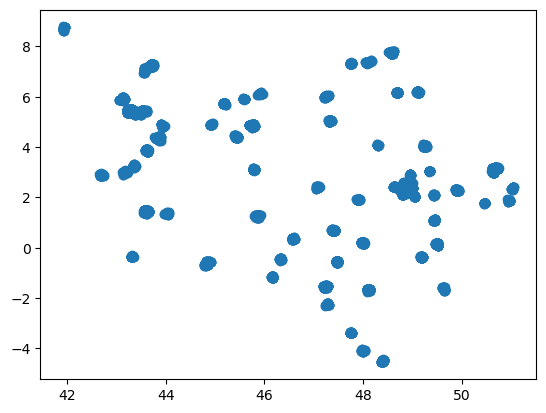

In [20]:
#Plotten der Datenpunkte

xs = []
ys = []
for city, size in data:
    path = "/home/jovyan/Documents/Cities/" + city + "/" + city + ".txt"
    #print(city)
    with open(path, "r") as file:
        file_content = file.read()
        # Example string with newline characters
        #multiline_string = "Line 1\nLine 2\nLine 3"

        # Using splitlines() method
        lines_list = file_content.splitlines()

        # Printing individual lines
        #for line in lines_list:
    #print(line)

        for line in lines_list:
            #print(line)
            x = ast.literal_eval(line)
            xs.append(x[0])
            ys.append(x[1])
plt.scatter(xs, ys)

Paris
Marseille
Lyon
Toulouse
Nice
Nantes
Montpellier
Strasbourg
Bordeaux
Lille
Rennes
Reims
Toulon
Saint-Étienne
Le Havre
Grenoble
Dijon
Angers
Villeurbanne
Nîmes
Clermont-Ferrand
Aix-en-Provence
Le Mans
Brest
Tours
Amiens
Limoges
Annecy
Boulogne-Billancourt
Perpignan
Metz
Besançon
Orléans
Seine-Saint-Denis
Rouen
Montreuil
Argenteuil
Mulhouse
Caen
Nancy
Roubaix
Tourcoing
Nanterre
Vitry-sur-Seine
Créteil
Avignon
Poitiers
Aubervilliers
Asnières-sur-Seine
Aulnay-sous-Bois
Colombes
Dunkirk
Versailles
Courbevoie
Cherbourg-en-Cotentin
Rueil-Malmaison
Béziers
La Rochelle
Champigny-sur-Marne
Pau
Saint-Maur-des-Fossés
Cannes
Antibes
Calais
Drancy
Mérignac
Saint-Nazaire
Ajaccio
Colmar
Issy-les-Moulineaux
Noisy-le-Grand
Vénissieux
Évry-Courcouronnes
Levallois-Perret
Cergy
Pessac
Valence (Drôme)
Bourges
Ivry-sur-Seine
Quimper
Clichy
La Seyne-sur-Mer
Antony
Troyes
Villeneuve-d'Ascq
Montauban
Pantin
Neuilly-sur-Seine
Sarcelles
Niort
Chambéry
Le Blanc-Mesnil
Lorient
Beauvais
Maisons-Alfort
Meaux
Nar

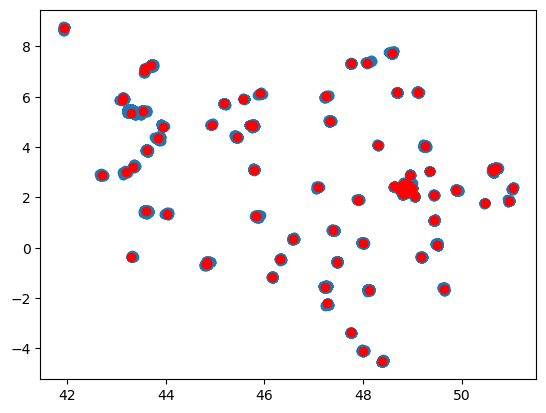

In [21]:
# Kontrolle mit den echten Koordinaten

xs2=[]
ys2=[]
for city, size in data:
    print(city)
    location = geolocator.geocode(city + ", France")
    xs2.append(location.latitude)
    ys2.append(location.longitude)

plt.scatter(xs, ys)
plt.scatter(xs2, ys2, color="red")